In [1]:
pip install yfinance


[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.linear_model import LinearRegression

# pandas and numpy are used for data manipulation in table
import pandas as pd
import numpy as np

# matplotlib and seaborn are used for plotting graphs for better understanding of the data
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# yahoo finance is used to fetch data of gold etf prices
import yfinance as yf
import datetime as dt

/var/folders/rn/7_8trjm533j6lw5bv3qjx8mh0000gn/T/ipykernel_4275/86218863.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


[*********************100%***********************]  1 of 1 completed


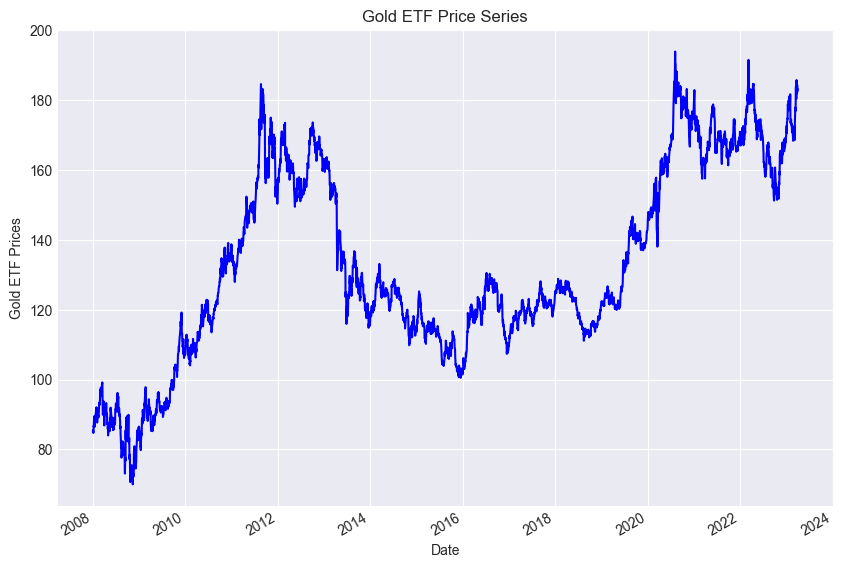

In [3]:
Df = yf.download('GLD', '2008-01-01', '2023-03-31', auto_adjust=True)

# Only keep close columns
Df = Df[['Close']]

# Drop rows with missing values
Df = Df.dropna()

# Plot the closing price of GLD
Df.Close.plot(figsize=(10, 7),color='b')
plt.ylabel("Gold ETF Prices")
plt.title("Gold ETF Price Series")
plt.show()

In [4]:
Df.describe()

,Close
count,3838.000000
mean,132.651597
std,27.290657
min,70.000000
25%,115.400000
50%,125.494999
75%,159.539993
max,193.889999


In [5]:
print(Df)

                 Close
Date                  
2008-01-02   84.860001
2008-01-03   85.570000
2008-01-04   85.129997
2008-01-07   84.769997
2008-01-08   86.779999
...                ...
2023-03-24  183.649994
2023-03-27  181.949997
2023-03-28  183.440002
2023-03-29  182.529999
2023-03-30  184.179993

[3838 rows x 1 columns]


In [6]:
type(Df)

pandas.core.frame.DataFrame

In [7]:
Df.isnull().values.any()

False

In [8]:
Df.head()

,Close
Date,
2008-01-02,84.860001
2008-01-03,85.570000
2008-01-04,85.129997
2008-01-07,84.769997
2008-01-08,86.779999


In [9]:
Df.tail()

,Close
Date,
2023-03-24,183.649994
2023-03-27,181.949997
2023-03-28,183.440002
2023-03-29,182.529999
2023-03-30,184.179993


In [10]:
Df['S_3'] = Df['Close'].rolling(window=3).mean()
Df['S_9'] = Df['Close'].rolling(window=9).mean()
Df['next_day_price'] = Df['Close'].shift(-1)

Df = Df.dropna()
X = Df[['S_3','S_9']]

# Define dependent variable
y = Df['next_day_price']

In [11]:
print(X)

                   S_3         S_9
Date                              
2008-01-14   88.790001   86.670000
2008-01-15   88.703334   87.017777
2008-01-16   88.076665   87.143333
2008-01-17   87.063332   87.295555
2008-01-18   86.873332   87.590000
...                ...         ...
2023-03-23  183.183334  180.958891
2023-03-24  184.276667  181.602224
2023-03-27  183.779999  182.171112
2023-03-28  183.013331  182.752223
2023-03-29  182.639999  183.192222

[3829 rows x 2 columns]


In [12]:
# Split the data into train and test dataset
t = .8
t = int(t*len(Df))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

In [13]:
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("Gold ETF Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 9 Days Moving Average (x2) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))

Linear Regression model
Gold ETF Price (y) = 1.20 * 3 Days Moving Average (x1) + -0.21 * 9 Days Moving Average (x2) + 0.45 (constant)


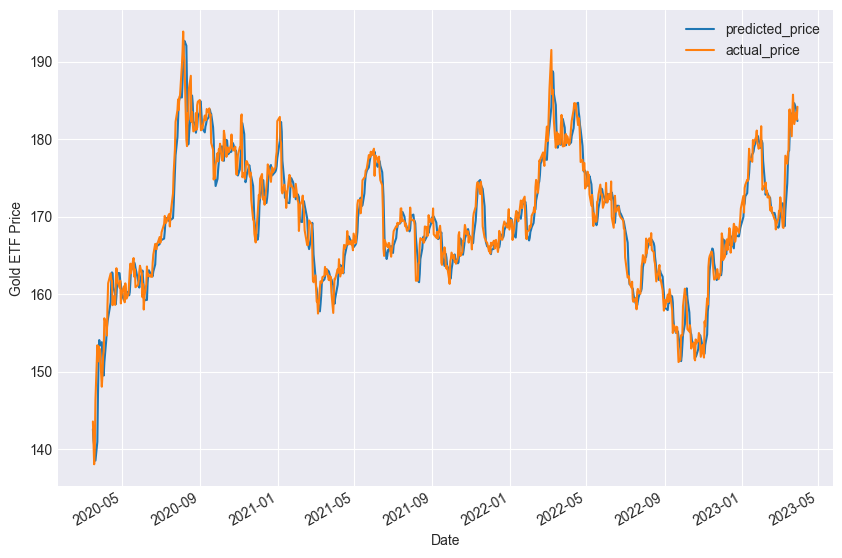

In [14]:
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold ETF Price")
plt.show()

In [15]:
r2_score = linear.score(X[t:], y[t:])*100
float("{0:.2f}".format(r2_score))

93.35

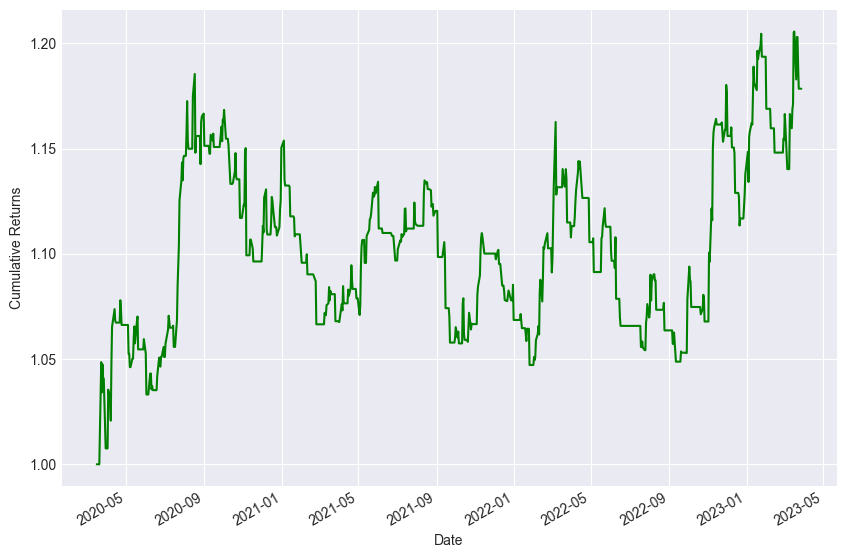

In [16]:
gold = pd.DataFrame()

gold['price'] = Df[t:]['Close']
gold['predicted_price_next_day'] = predicted_price
gold['actual_price_next_day'] = y_test
gold['gold_returns'] = gold['price'].pct_change().shift(-1)

gold['signal'] = np.where(gold.predicted_price_next_day.shift(1) < gold.predicted_price_next_day,1,0)

gold['strategy_returns'] = gold.signal * gold['gold_returns']
((gold['strategy_returns']+1).cumprod()).plot(figsize=(10,7),color='g')
plt.ylabel('Cumulative Returns')
plt.show()

In [17]:
# Calculate sharpe ratio
sharpe = gold['strategy_returns'].mean()/gold['strategy_returns'].std()*(252**0.5)
'Sharpe Ratio %.2f' % (sharpe)

'Sharpe Ratio 0.52'

In [18]:
print(Df)

                 Close         S_3         S_9  next_day_price
Date                                                          
2008-01-14   89.540001   88.790001   86.670000       87.989998
2008-01-15   87.989998   88.703334   87.017777       86.699997
2008-01-16   86.699997   88.076665   87.143333       86.500000
2008-01-17   86.500000   87.063332   87.295555       87.419998
2008-01-18   87.419998   86.873332   87.590000       88.169998
...                ...         ...         ...             ...
2023-03-23  185.740005  183.183334  180.958891      183.649994
2023-03-24  183.649994  184.276667  181.602224      181.949997
2023-03-27  181.949997  183.779999  182.171112      183.440002
2023-03-28  183.440002  183.013331  182.752223      182.529999
2023-03-29  182.529999  182.639999  183.192222      184.179993

[3829 rows x 4 columns]


In [19]:
current_date = dt.datetime.now()
data = yf.download('GLD', '2008-06-01', current_date, auto_adjust=True)
data['S_3'] = data['Close'].rolling(window=3).mean()
data['S_9'] = data['Close'].rolling(window=9).mean()
data = data.dropna()
data['predicted_gold_price'] = linear.predict(data[['S_3', 'S_9']])
data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price,"Buy","Don't buy")
data.tail(1)[['signal','predicted_gold_price']].T

[*********************100%***********************]  1 of 1 completed


/var/folders/rn/7_8trjm533j6lw5bv3qjx8mh0000gn/T/ipykernel_4275/3503982850.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['predicted_gold_price'] = linear.predict(data[['S_3', 'S_9']])
/var/folders/rn/7_8trjm533j6lw5bv3qjx8mh0000gn/T/ipykernel_4275/3503982850.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price,"Buy","Don't buy")


Date,2023-06-16
signal,Buy
predicted_gold_price,181.189505
